# pypsps: demo of learning UTE and ATE from simulated datasets

This notebook illustrates how to use `pypsps` for

* how to train PSPS deep nets from causal (simulated) datasets
 
* how to use model predictions/estimates to obtain UTE / ATE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import tensorflow as tf
import tensorflow.keras as tfk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

In [3]:
import pypsps
import pypsps.keras.layers
import pypsps.keras.losses
import pypsps.keras.metrics
import pypsps.keras.models
import pypsps.keras.callbacks
import pypsps.utils
import pypsps.inference
import pypsps.datasets

import pypress # for regularizers

In [4]:
import sklearn.metrics

def _eval_propensity(y_true, y_score):

    y_comb = pd.DataFrame({"treatment": y_true, "propensity_score": y_score})
    sns.displot(data=y_comb, x="propensity_score", hue="treatment")
    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = sklearn.metrics.auc(recall, precision)
    print(auc_precision_recall, output_data[:, 1].mean())

    plt.plot(recall, precision)
    plt.title("AUPR")
    plt.grid()
    plt.show()

# Load datasets

In [5]:
feat_cols = []
treat_col = None
outcome_col = None

## Kang-Schafer

In [6]:
ks_sampler = pypsps.datasets.KangSchafer(true_ate=10, seed=123) 
ks_data = ks_sampler.sample(n_samples=1000)
df = ks_data.to_data_frame()

treat_col = "treatment"
outcome_col = "outcome"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))
feat_cols = [c for c in feat_cols if "x" in c]

df.head()

,outcome,treatment,z1,z2,z3,z4,x1,x2,x3,x4
0,185.861788,1,-1.085631,0.997345,0.282978,-1.506295,0.581110,10.745574,0.202998,379.901059
1,185.488662,1,-0.578600,1.651437,-2.426679,-0.428913,0.748787,11.058150,0.282511,450.395521
2,222.810098,0,1.265936,-0.866740,-0.678886,-0.094709,1.883192,9.809357,0.180959,362.466410
3,229.073054,0,1.491390,-0.638902,-0.443982,-0.434351,2.107906,9.882625,0.188639,358.221742
4,318.044041,0,2.205930,2.186786,1.004054,0.386186,3.013087,10.216971,0.326506,509.539087


# Lalonde

In [7]:
l_data = pypsps.datasets.lalonde.Lalonde(observational_control=True, add_is_unemployed_features=True)
df = l_data.to_data_frame()

treat_col = "treatment"
outcome_col = "earnings1978"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))

df.head()

Reading data from http://www.nber.org/~rdehejia/data/nswre74_control.txt
Reading data from http://www.nber.org/~rdehejia/data/nswre74_treated.txt
Reading data from http://www.nber.org/~rdehejia/data/cps_controls.txt


,earnings1978,treatment,earnings1974,married,age,earnings1975,hispanic,education,black,nodegree,is_unemployed_1974,is_unemployed_1975
0,9930.0460,1.0,0.0,1.0,37.0,0.0,0.0,11.0,1.0,1.0,1.0,1.0
1,3595.8940,1.0,0.0,0.0,22.0,0.0,1.0,9.0,0.0,1.0,1.0,1.0
2,24909.4500,1.0,0.0,0.0,30.0,0.0,0.0,12.0,1.0,0.0,1.0,1.0
3,7506.1460,1.0,0.0,0.0,27.0,0.0,0.0,11.0,1.0,1.0,1.0,1.0
4,289.7899,1.0,0.0,0.0,33.0,0.0,0.0,8.0,1.0,1.0,1.0,1.0


## Lunceford-Davidian

In [8]:
ld_sampler = pypsps.datasets.LuncefordDavidian(association="strong", seed=123)
ld_data = ld_sampler.sample(n_samples=1000)
df = ld_data.to_data_frame()

treat_col = "treatment"
outcome_col = "outcome"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))
feat_cols = [c for c in feat_cols if "x" in c]

df.head()

,outcome,treatment,x1,x2,x3,z1,z2,z3
0,3.780973,1,-0.344101,1.484932,0,-0.252382,-0.534471,0
1,-0.177951,1,0.750124,-0.736719,0,-0.311732,0.473684,0
2,2.675636,0,-1.185921,0.732745,0,0.831504,1.197108,0
3,1.562883,1,-0.206458,-1.523020,0,1.279420,1.554854,0
4,3.424068,1,-1.812288,-0.374206,0,1.040326,1.188986,0


In [9]:
ld_data.naive_ate()

1.3088308775537878

# Summary stats of Causal dataset

In [10]:
print(df.groupby(treat_col).mean().T.round(2))

treatment     0     1
outcome    0.51  1.82
x1        -1.09 -0.80
x2        -0.83 -1.17
x3         0.20  0.28
z1         1.03  1.00
z2         1.03  1.04
z3         0.36  0.42


In [11]:
feat_cols

['x1', 'x2', 'x3']

# Feature, treatment, outcome: setup for model training and inference

In [12]:
X, treatment, y = df[feat_cols].astype(float), df[[treat_col]], df[[outcome_col]]
X.shape, treatment.shape, y.shape

((1000, 3), (1000, 1), (1000, 1))

In [13]:
# Naive difference in means
df.groupby(treat_col)[outcome_col].mean()

treatment
0    0.509396
1    1.818227
Name: outcome, dtype: float64

In [14]:
ld_data.naive_ate()

1.3088308775537878

In [15]:
# Scale features using a standard scaler (for sake of illustration don't do train/test split; in practice use train/test split for scaling as well)
import sklearn

# scale only features that have > 2 values (non-binary)
val_counts = X.nunique()
binary_cols = val_counts[val_counts == 2].index.tolist()

X_nonbinary = X.drop(binary_cols, axis=1)
X_s = pd.concat([X[binary_cols], 
                 pd.DataFrame(sklearn.preprocessing.scale(X_nonbinary), index=X_nonbinary.index, columns=X_nonbinary.columns)], axis=1)
X_s

,x3,x1,x2
0,0.0,0.605236,2.498541
1,0.0,1.732671,0.276365
2,0.0,-0.262133,1.746176
3,0.0,0.747056,-0.510122
4,0.0,-0.907510,0.638963
...,...,...,...
995,0.0,-1.397577,0.684494
996,0.0,-1.568665,-0.807166
997,0.0,-1.629278,0.160043
998,0.0,-1.040693,0.214284


# Model architecture

In [18]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(4, X_s.shape[1])
model.summary()

/Users/georg/Projects/pypsps/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn         │ (None, 3)         │         12 │ features[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn_and_tr… │ (None, 4)         │          0 │ features_bn[0][0… │
│ (Concatenate)       │                   │            │ treatment[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │         50 │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │         40 │ features_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome_hidden_and… │ (None, 14)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_0    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_1    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_2    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_3    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_0       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_1       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_2       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                 

 Total params: 680 (2.66 KB)

 Trainable params: 634 (2.48 KB)

 Non-trainable params: 46 (184.00 B)

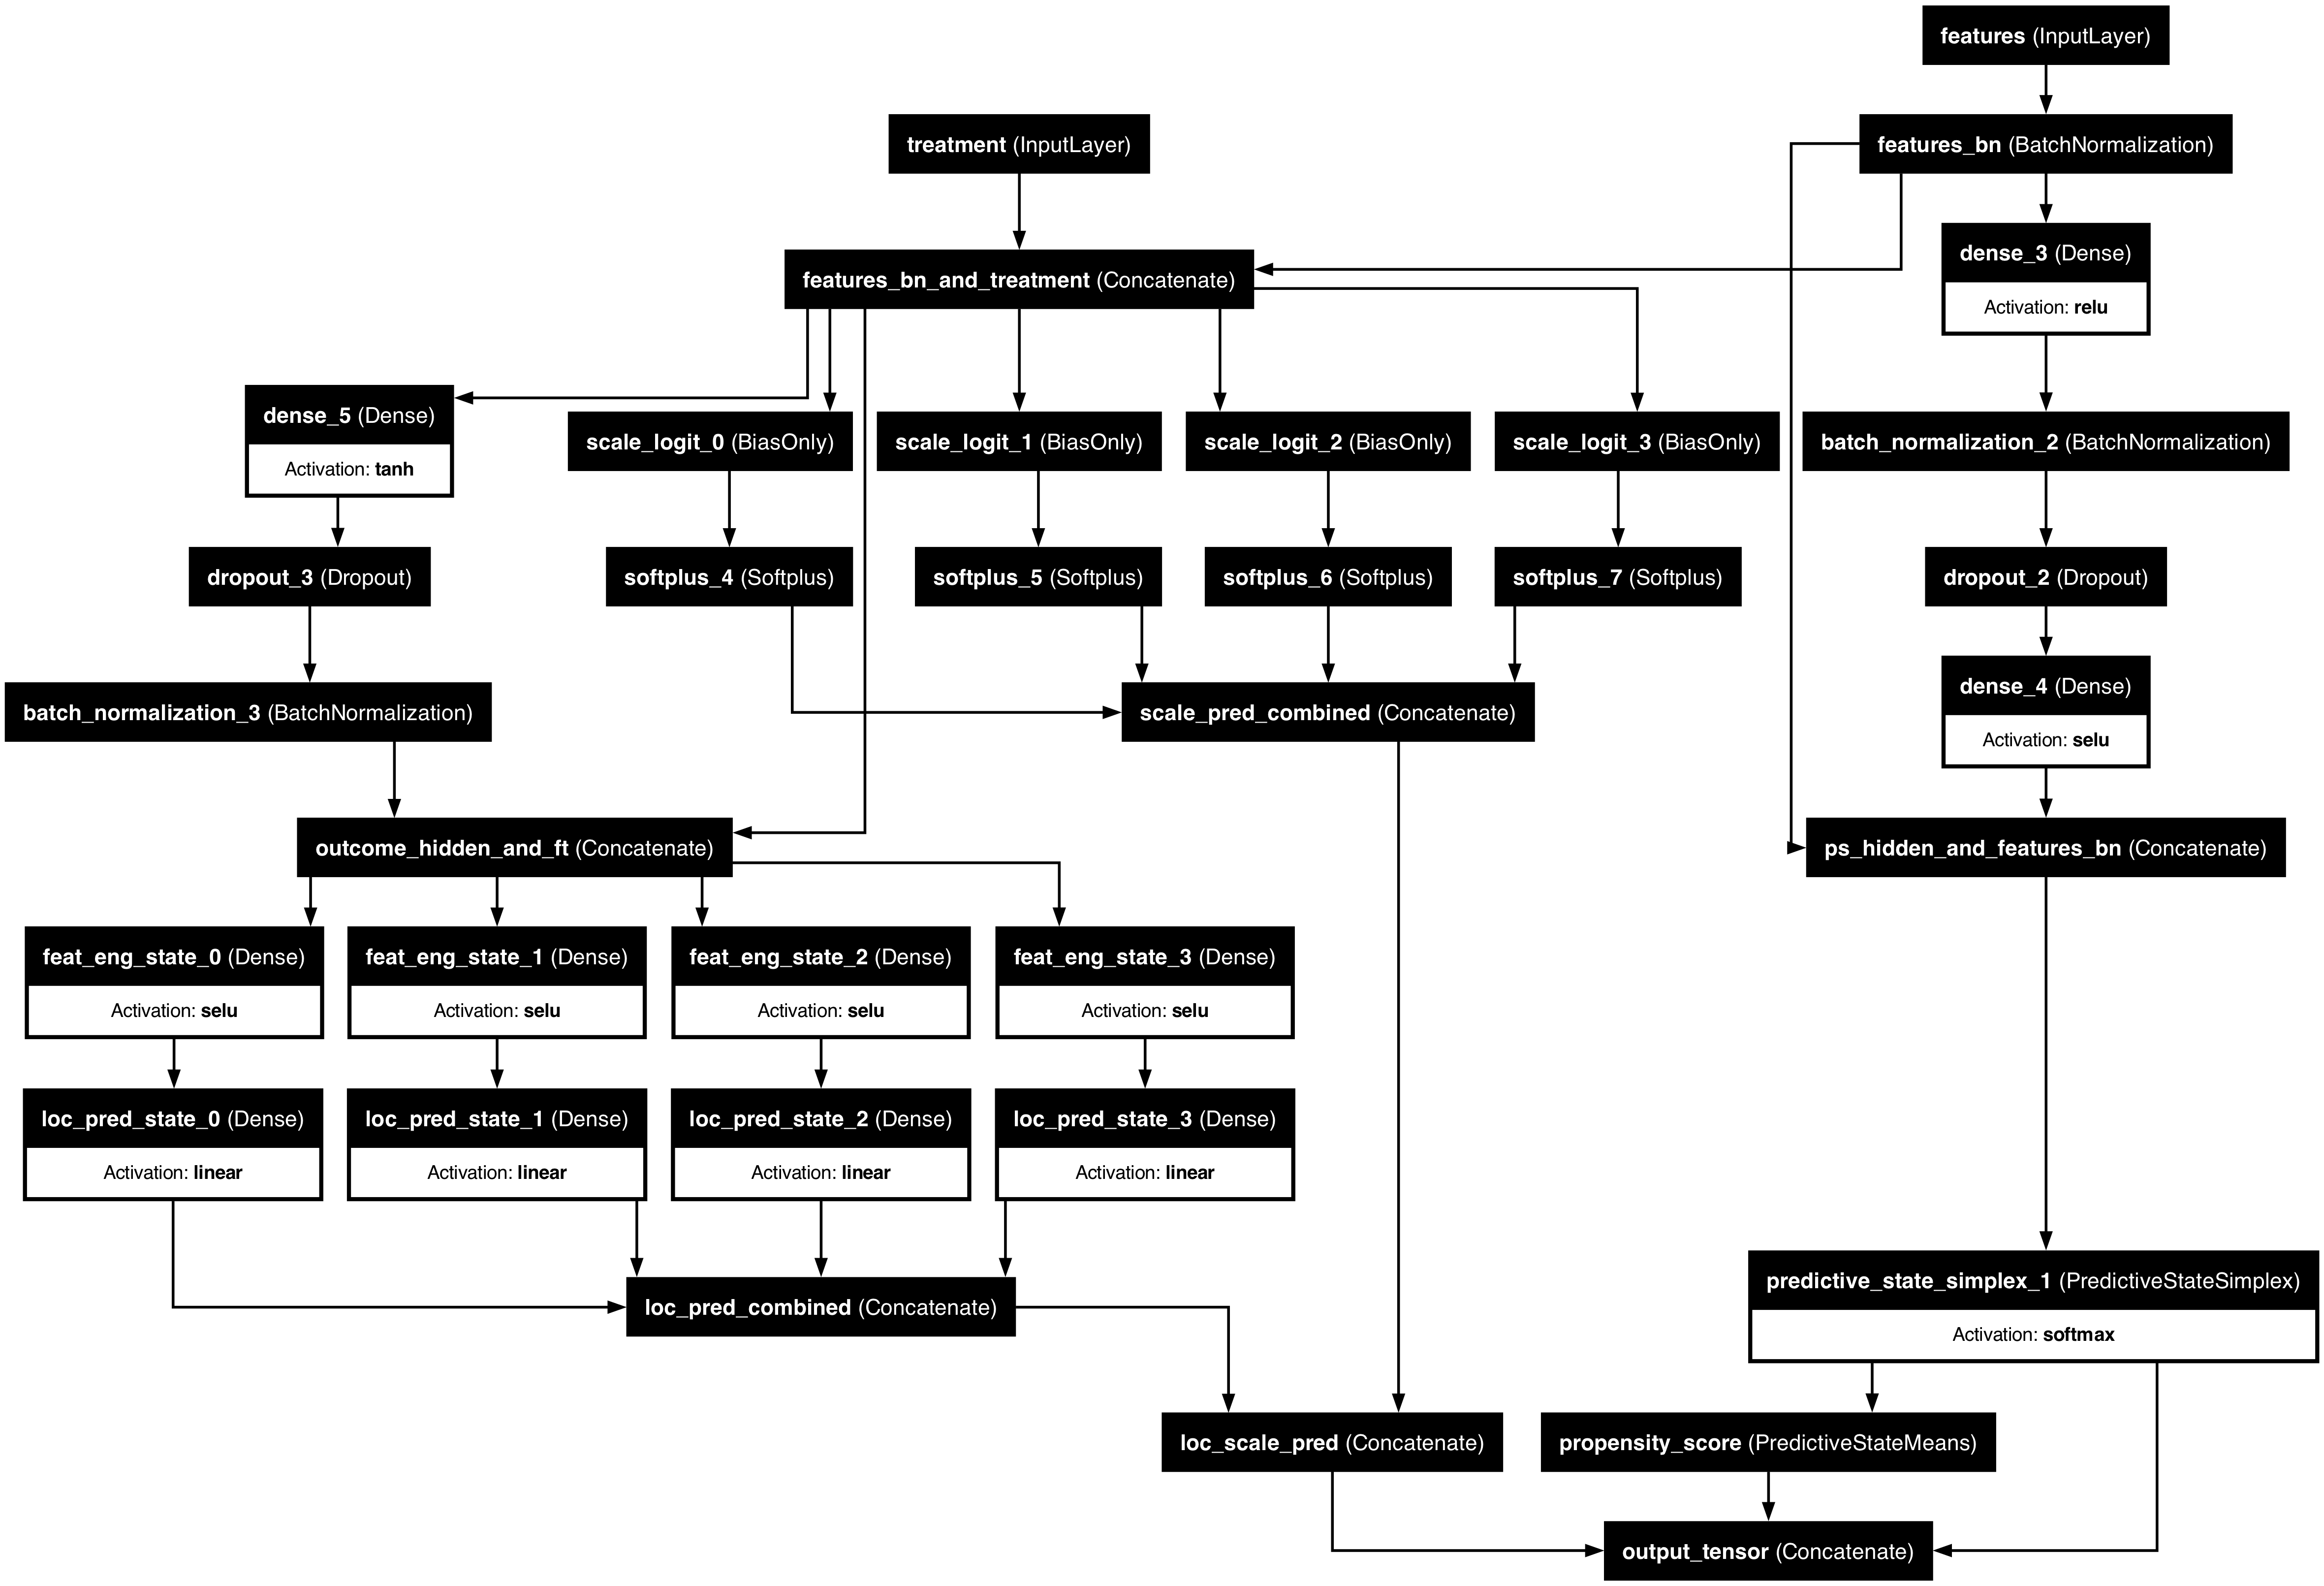

In [19]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_layer_activations=True)

<Axes: >

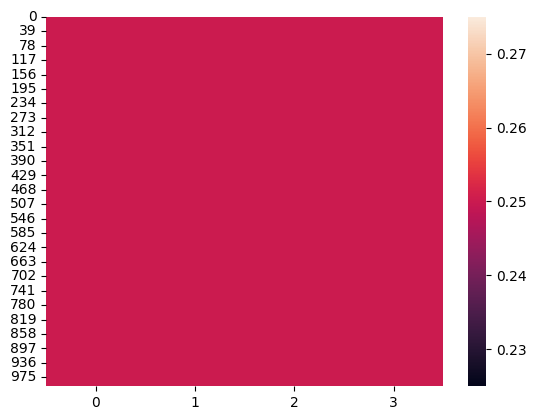

In [20]:
inputs = [X_s.values, treatment.values]
outputs = np.hstack([y.values, treatment.values])

preds = model.predict(inputs, verbose=0)

outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(preds, n_outcome_pred_cols=2, n_treatment_pred_cols=1)
sns.heatmap(weights)

## Train model

In [21]:
# Preparet inputs and outputs (y_true) for losses / metrics and .fit() / .predict()
input_data = [X_s.values, treatment.values]
output_data = np.hstack([y.values, treatment.values])

# pre-training model predictions
y_pred = model.predict(input_data, verbose=0)
y_pred.shape

(1000, 13)

In [22]:
op, wp, tp = pypsps.utils.split_y_pred(y_pred, 
                                       model.loss._outcome_loss._n_outcome_pred_cols,
                                       model.loss._treatment_loss._n_treatment_pred_cols)
op

array([[ 1.8946984 ,  1.0391251 , -0.2039508 , ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [ 2.4403763 ,  0.8520108 , -0.21684617, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [ 0.6201664 ,  0.7654852 ,  0.17457303, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       ...,
       [-1.5578103 , -0.20465147, -0.6304454 , ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [-1.094318  , -0.04092203, -0.45039123, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [ 1.4137483 ,  0.5953597 ,  0.64886343, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ]], dtype=float32)

In [23]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(5, X_s.shape[1])
model.summary()

/Users/georg/Projects/pypsps/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn         │ (None, 3)         │         12 │ features[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn_and_tr… │ (None, 4)         │          0 │ features_bn[0][0… │
│ (Concatenate)       │                   │            │ treatment[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │         50 │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │         40 │ features_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome_hidden_and… │ (None, 14)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_0    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_1    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_2    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_3    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_4    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_0       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_1       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                 

 Total params: 777 (3.04 KB)

 Trainable params: 731 (2.86 KB)

 Non-trainable params: 46 (184.00 B)

In [24]:
psps_outcome_loss = pypsps.keras.losses.OutcomeLoss(
    loss=pypsps.keras.neglogliks.NegloglikNormal(reduction="none"), reduction="sum_over_batch_size",
    n_outcome_true_cols=1,
    n_outcome_pred_cols=2,
    n_treatment_pred_cols=1,
)
psps_treat_loss = pypsps.keras.losses.TreatmentLoss(loss=tf.keras.losses.BinaryCrossentropy(reduction="none"), 
                                                    reduction="sum_over_batch_size",
                                                       n_outcome_true_cols=1,
    n_outcome_pred_cols=2,
    n_treatment_pred_cols=1,)
psps_outcome_loss(output_data, y_pred), psps_treat_loss(output_data, y_pred)

(<tf.Tensor: shape=(), dtype=float32, numpy=6.4922338>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6991795>)

In [25]:
psps_causal_loss = pypsps.keras.losses.CausalLoss(outcome_loss=psps_outcome_loss,
                                  treatment_loss=psps_treat_loss,
                                  alpha=1.,
                                  outcome_loss_weight=0.01,
                                  predictive_states_regularizer=pypress.keras.regularizers.DegreesOfFreedom(
                                      0.01, df=5 - 1),
                                  reduction="sum_over_batch_size")

# Test loss function
psps_causal_loss(output_data, y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=0.7941018>

In [26]:
model.compile(loss=psps_causal_loss, 
              optimizer=tfk.optimizers.Nadam(learning_rate=0.01), 
              metrics=[pypsps.keras.metrics.PropensityScoreBinaryCrossentropy(),
                      pypsps.keras.metrics.PropensityScoreAUC(curve="PR"),
                      pypsps.keras.metrics.OutcomeMeanSquaredError()])

history = model.fit(input_data, output_data, epochs=50, batch_size=64,
                    verbose=2, validation_split=0.2,
                    callbacks=pypsps.keras.callbacks.recommended_callbacks())


Epoch 1/50
13/13 - 5s - 355ms/step - binary_crossentropy: 0.6844 - loss: 0.7667 - mean_squared_error: 3.9199 - propensity_score_auc_3: 0.6173 - val_binary_crossentropy: 0.6832 - val_loss: 0.7482 - val_mean_squared_error: 3.4099 - val_propensity_score_auc_3: 0.6339 - learning_rate: 0.0100
Epoch 2/50
13/13 - 0s - 5ms/step - binary_crossentropy: 0.6570 - loss: 0.7157 - mean_squared_error: 3.2614 - propensity_score_auc_3: 0.6612 - val_binary_crossentropy: 0.6723 - val_loss: 0.7280 - val_mean_squared_error: 3.0978 - val_propensity_score_auc_3: 0.6507 - learning_rate: 0.0100
Epoch 3/50
13/13 - 0s - 5ms/step - binary_crossentropy: 0.6455 - loss: 0.6951 - mean_squared_error: 3.0910 - propensity_score_auc_3: 0.6787 - val_binary_crossentropy: 0.6665 - val_loss: 0.7187 - val_mean_squared_error: 3.0396 - val_propensity_score_auc_3: 0.6681 - learning_rate: 0.0100
Epoch 4/50
13/13 - 0s - 5ms/step - binary_crossentropy: 0.6433 - loss: 0.6891 - mean_squared_error: 3.0905 - propensity_score_auc_3: 0.68

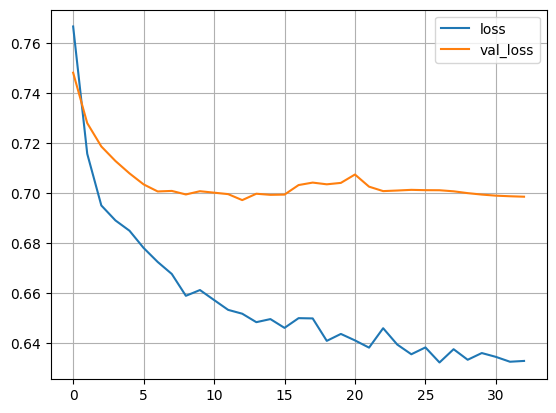

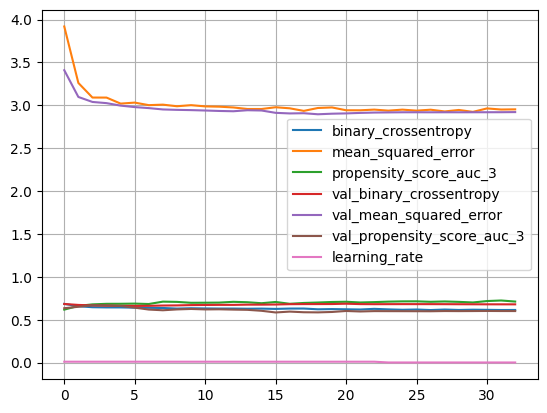

In [27]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.grid()
plt.show()
pd.DataFrame(history.history).drop(["loss", "val_loss"], axis=1).plot()
plt.grid()


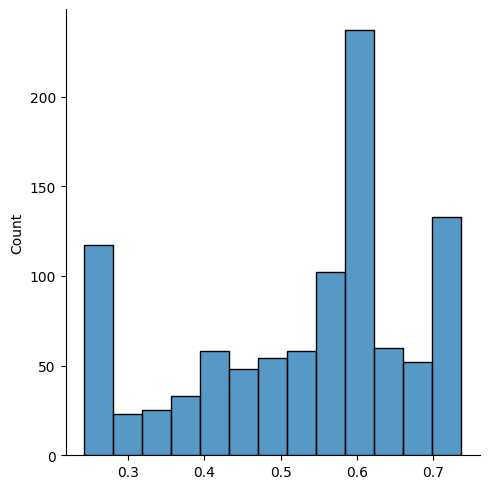

In [28]:
y_pred = model.predict(input_data, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(y_pred, 
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._treatment_loss._n_treatment_pred_cols)
sns.displot(pd.Series(propensity_score.ravel()))

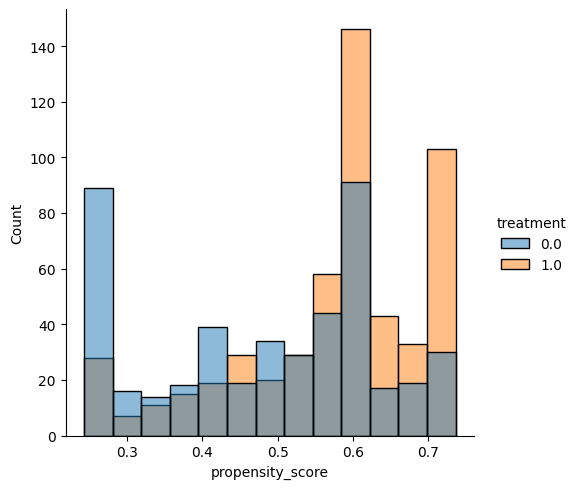

0.6972487589190284 0.541


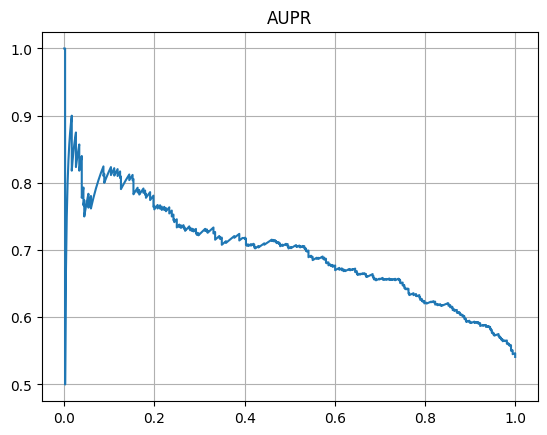

<Axes: >

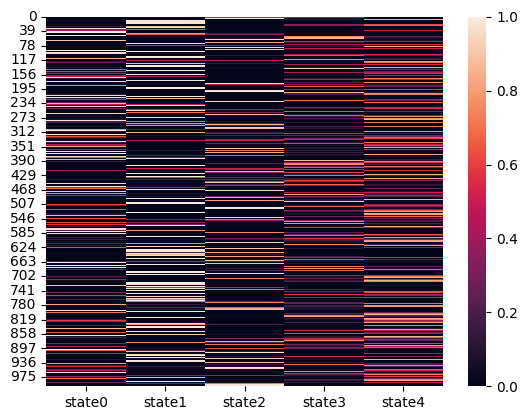

In [29]:
y_pred = model.predict(input_data, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(y_pred,
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._treatment_loss._n_treatment_pred_cols)
_eval_propensity(output_data[:, 1], propensity_score.ravel())
weights_df = pd.DataFrame(weights, index=X_s.index, columns=["state" + str(i) for i in range(weights.shape[1])])
sns.heatmap(weights_df.round(2))

In [30]:
psps_causal_loss = pypsps.keras.losses.CausalLoss(outcome_loss=psps_outcome_loss,
                                  treatment_loss=psps_treat_loss,
                                  alpha=1.,
                                  outcome_loss_weight=1.0,
                                  predictive_states_regularizer=pypress.keras.regularizers.DegreesOfFreedom(0.01, df=5 - 1),
                                  reduction="sum_over_batch_size")
# Test loss function
print(psps_causal_loss(output_data, y_pred))

model.compile(loss=psps_causal_loss, 
              optimizer=tfk.optimizers.Nadam(learning_rate=0.01), 
              metrics=[pypsps.keras.metrics.PropensityScoreBinaryCrossentropy()])

history = model.fit(input_data, output_data, epochs=50, batch_size=64,
                    verbose=2, validation_split=0.2,
                    # callbacks=all_callbacks
                   )

tf.Tensor(2.6031866, shape=(), dtype=float32)
Epoch 1/50
13/13 - 4s - 345ms/step - binary_crossentropy: 0.6267 - loss: 2.5800 - val_binary_crossentropy: 0.6829 - val_loss: 2.5883
Epoch 2/50
13/13 - 0s - 5ms/step - binary_crossentropy: 0.6304 - loss: 2.5515 - val_binary_crossentropy: 0.6825 - val_loss: 2.5554
Epoch 3/50
13/13 - 0s - 5ms/step - binary_crossentropy: 0.6271 - loss: 2.5153 - val_binary_crossentropy: 0.6816 - val_loss: 2.5226
Epoch 4/50
13/13 - 0s - 4ms/step - binary_crossentropy: 0.6299 - loss: 2.4953 - val_binary_crossentropy: 0.6766 - val_loss: 2.5100
Epoch 5/50
13/13 - 0s - 4ms/step - binary_crossentropy: 0.6408 - loss: 2.4844 - val_binary_crossentropy: 0.6742 - val_loss: 2.5124
Epoch 6/50
13/13 - 0s - 4ms/step - binary_crossentropy: 0.6292 - loss: 2.4838 - val_binary_crossentropy: 0.6702 - val_loss: 2.4959
Epoch 7/50
13/13 - 0s - 4ms/step - binary_crossentropy: 0.6253 - loss: 2.4588 - val_binary_crossentropy: 0.6707 - val_loss: 2.4879
Epoch 8/50
13/13 - 0s - 4ms/step - 

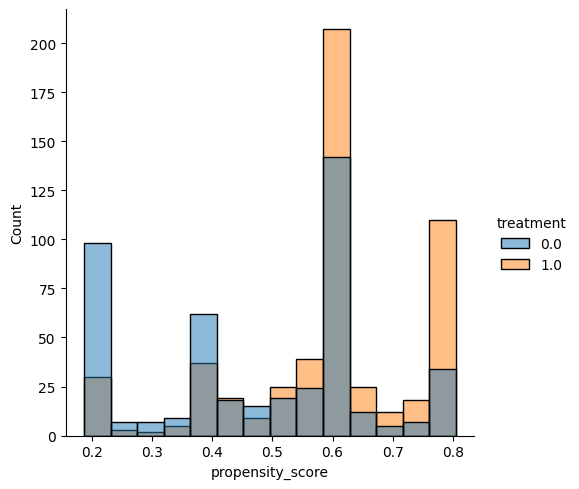

0.6991586061977354 0.541


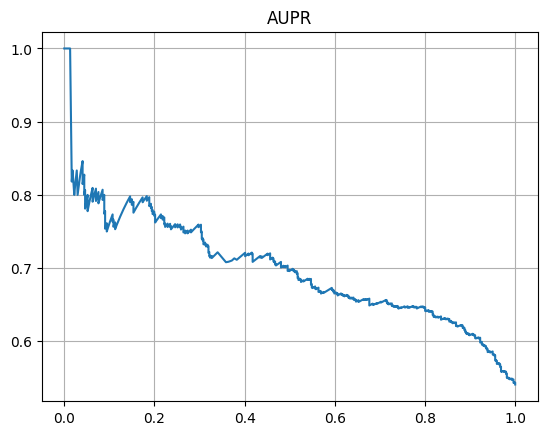

<Axes: >

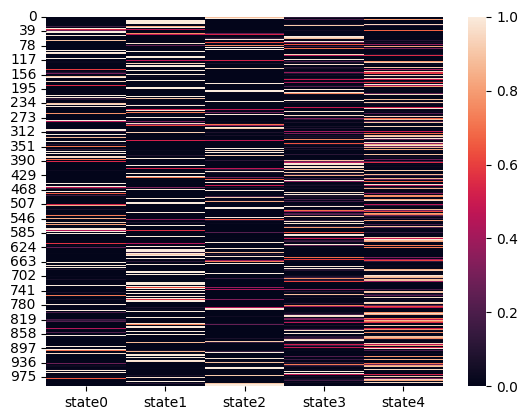

In [31]:
y_pred = model.predict(input_data, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(y_pred,
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._treatment_loss._n_treatment_pred_cols)
_eval_propensity(output_data[:, 1], propensity_score.ravel())
weights_df = pd.DataFrame(weights, index=X_s.index, columns=["state" + str(i) for i in range(weights.shape[1])])
sns.heatmap(weights_df.round(2))

In [32]:
mean_pred, scale_pred = pypsps.utils.split_outcome_pred(outcome_preds, 2)

In [33]:
tfk.losses.BinaryCrossentropy(reduction="sum")(y_true=treatment.values, y_pred=propensity_score)

<tf.Tensor: shape=(), dtype=float32, numpy=633.3578>

In [34]:
# This loss should match to above.
psps_treat_loss.reduction = "sum"
psps_treat_loss(output_data, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=633.3578>

In [35]:
pypsps.keras.metrics.PropensityScoreBinaryCrossentropy()(output_data, y_pred).numpy()

0.63335776

In [36]:
y_df = pd.DataFrame(mean_pred, columns=["y_pred" + str(i) for i in range(mean_pred.shape[1])])
y_df["y_pred_avg"] = pypsps.utils.agg_outcome_pred(y_pred, 
                                                   model.loss._outcome_loss._n_outcome_pred_cols,                  
                                                   model.loss._treatment_loss._n_treatment_pred_cols)[:, 0]
y_df["outcome"] = y.values

<Axes: >

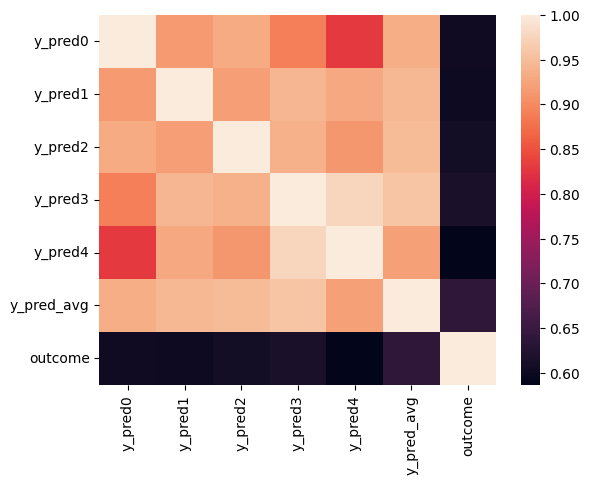

In [37]:
sns.heatmap(y_df.corr())

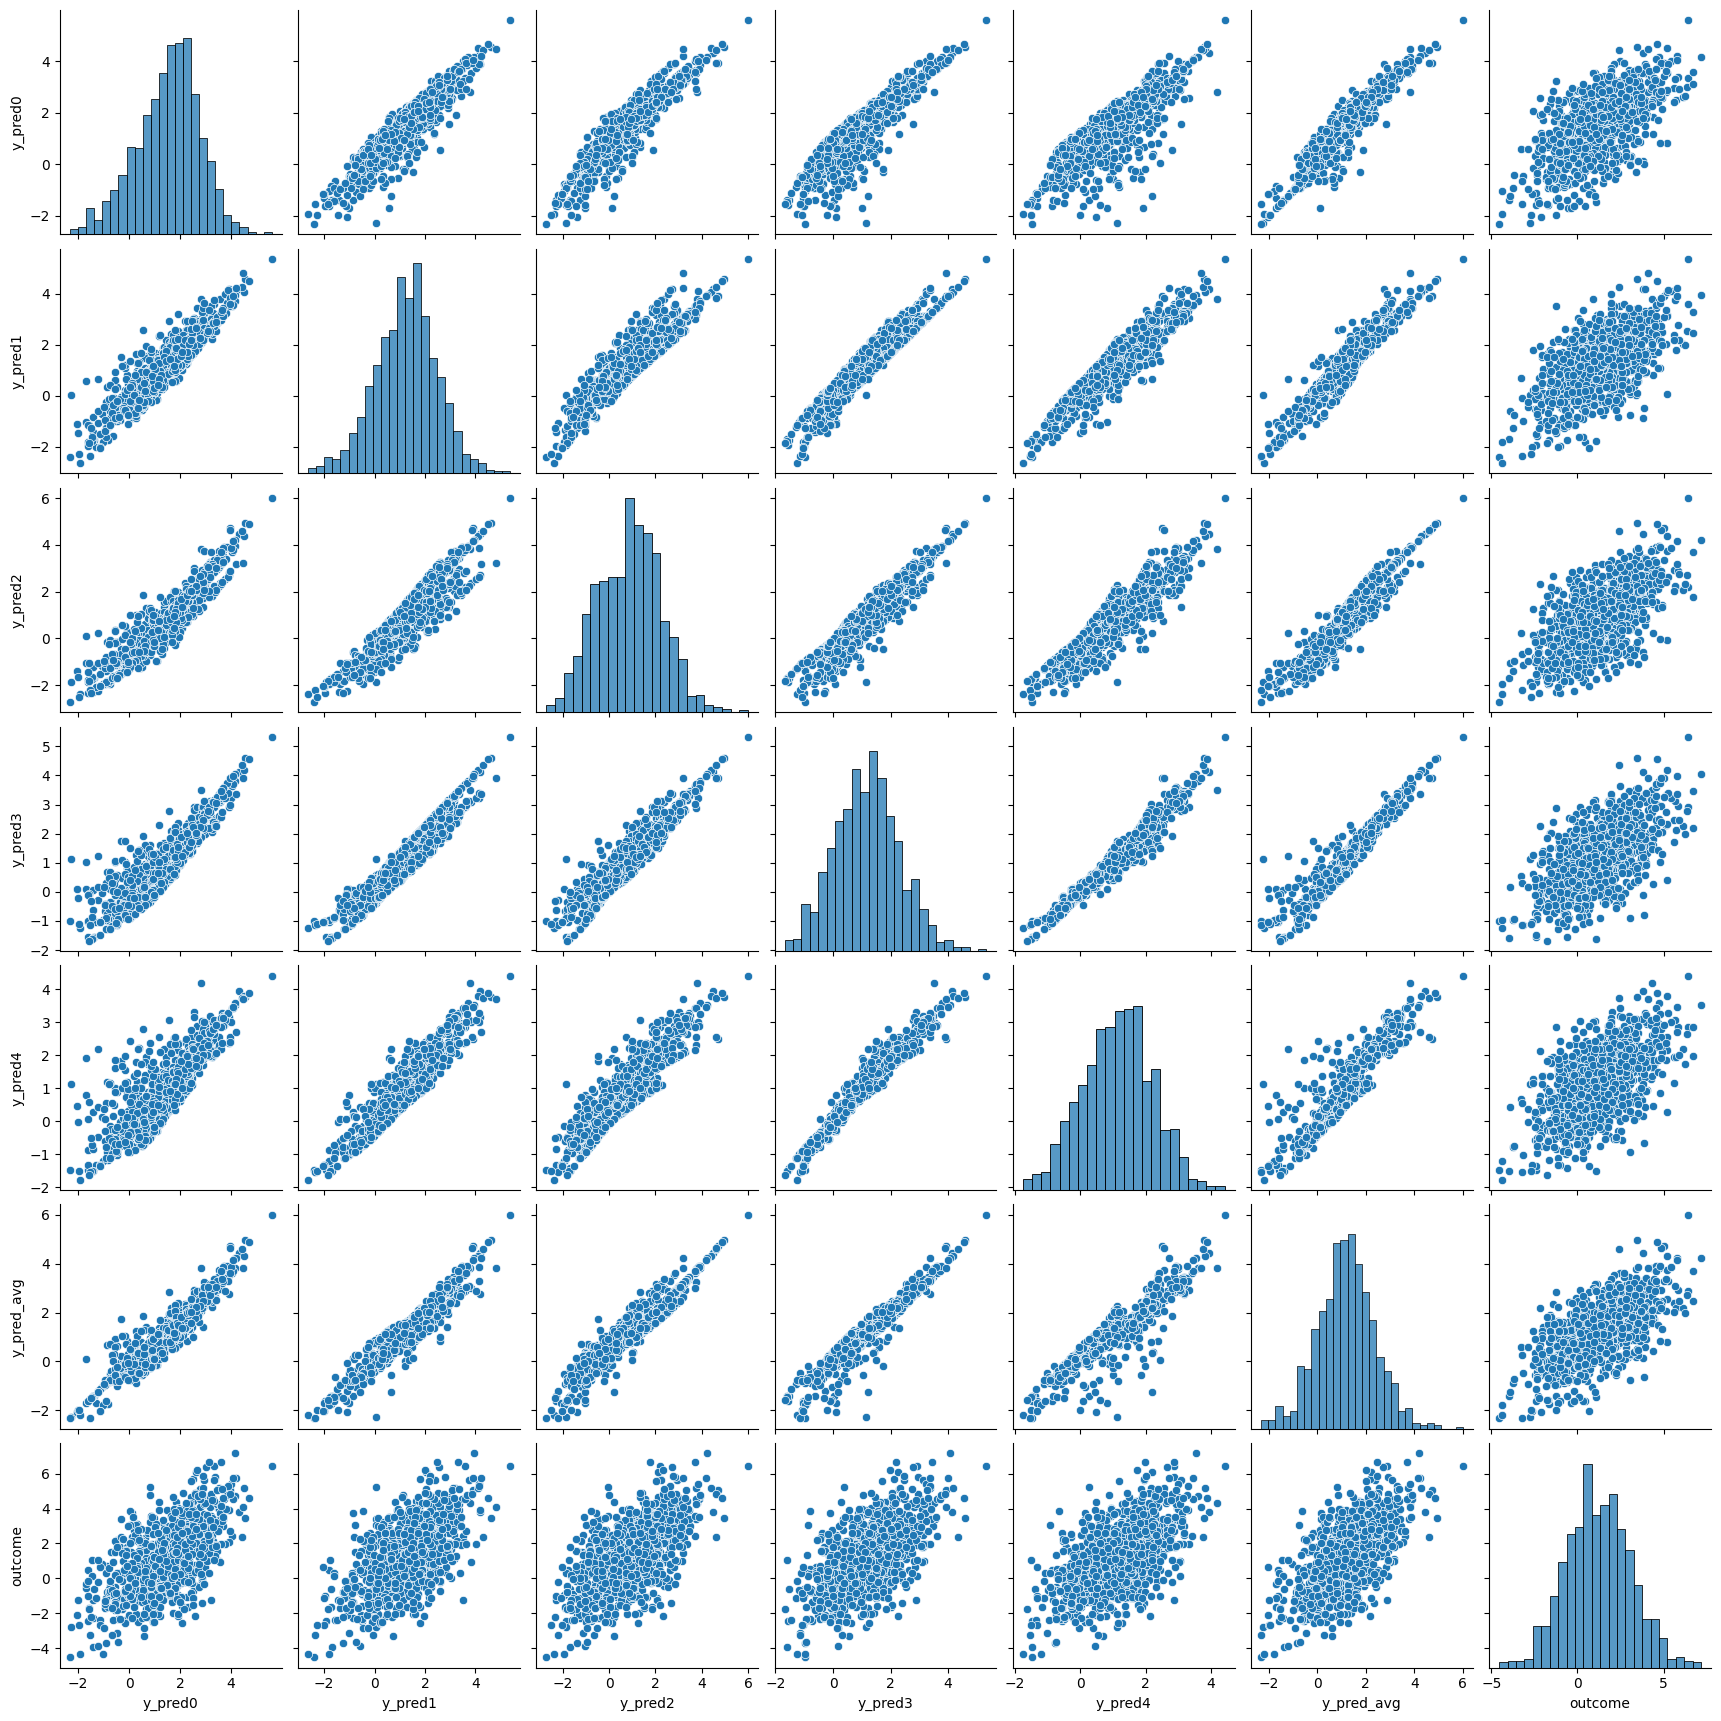

In [38]:
sns.pairplot(y_df)

<Axes: >

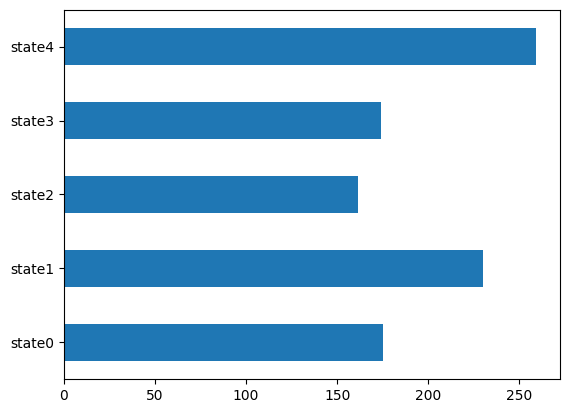

In [39]:
weights_df.sum().plot.barh()

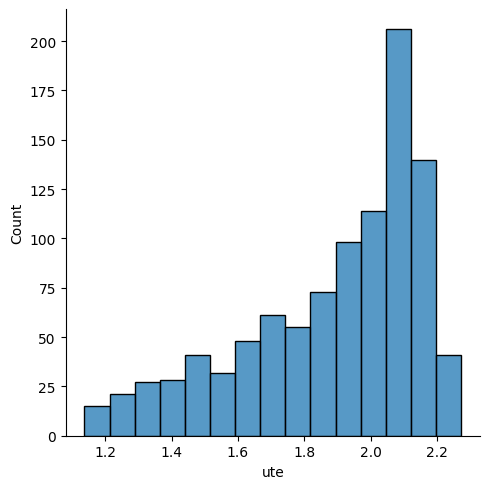

In [40]:
sns.displot(pypsps.inference.predict_ute_binary(model, X_s))

In [41]:
pypsps.inference.predict_ate_binary(model, X_s)

1.8871014

## Appendix (debug)
